In [1]:
# langgraph_mcp_agent.py
from typing import TypedDict, List, Literal, Annotated
from operator import add as list_add
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from mcp_add_tool import add  # Import the MCP tool
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# Define the agent's state
class InputState(TypedDict):
    query: str

class OutputState(TypedDict):
    agent_output: str

class AgentState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], list_add]

In [4]:
tools = [add]
llm = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [ ]:
def call_llm(state: AgentState) -> AgentState:
    # Add system prompt at the top
    system = SystemMessage(content="""
Use the `add` tool to add numbers. Once you’ve received the result, respond with the answer.
Don’t call the tool again after using it once.
""")

    messages = state["messages"]
    if not messages:
        # Initial step
        messages = [system, HumanMessage(content=state["query"])]
    else:
        messages = [system] + messages

    response = llm.invoke(messages)

    state["messages"].append(response)
    state["agent_output"] = response.content
    return state


In [ ]:
def call_tools(state: AgentState) -> AgentState:
    last_msg = state["messages"][-1]

    # Only respond if tool_calls exist
    if not hasattr(last_msg, "tool_calls") or not last_msg.tool_calls:
        return state

    # For each tool call in the assistant message
    for tool_call in last_msg.tool_calls:
        tool_id = tool_call["id"]
        tool_args = tool_call["args"]
        tool_name = tool_call["name"]

        # 🛡️ Avoid duplicate responses
        if any(isinstance(m, ToolMessage) and m.tool_call_id == tool_id for m in state["messages"]):
            continue

        if tool_name == "add":
            tool_result = add.invoke(tool_args)
            state["messages"].append(
                ToolMessage(
                    tool_call_id=tool_id,
                    content=tool_result
                )
            )

    return state


In [ ]:
def should_continue(state: AgentState) -> Literal["tools", END]:
    last = state["messages"][-1]
    return "tools" if getattr(last, "tool_calls", None) else END


In [8]:
# Step 4: LangGraph wiring
def build_graph():
    graph = StateGraph(AgentState)
    graph.add_node("call_llm", call_llm)
    graph.add_node("call_tools", call_tools)
    graph.set_entry_point("call_llm")
    graph.add_conditional_edges("call_llm", should_continue, {
        "tools": "call_tools",
        END: END
    })
    graph.add_edge("call_tools", "call_llm")
    return graph.compile()

In [9]:
add_agent = build_graph()

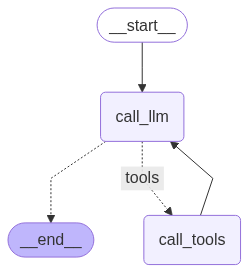

In [10]:
mermaid_png = add_agent.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
display(Image(mermaid_png))

In [11]:
query = ("Add 20 and 30")
state = {"query": query, "messages": []}
add_agent.invoke(state)

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_Q82KPplKck8ceZ30MbWJbuMf", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}